In [165]:
import json
import sys
sys.path.append("..")
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from collections import defaultdict, Counter, namedtuple
from pathlib import Path
from src.dnn.loaders.VARdataloader import DataLoaderVAR as DataLoader

PATH_EXP = "/data/bacteria/experiments/autoencoders/6mer/27122023-5"

encoder = tf.keras.models.load_model(f"{PATH_EXP}/models/encoder.keras")

In [166]:
list_fcgr = list(Path("/data/bacteria/experiments/autoencoders/6mer/fcgr").rglob("*/*.npy"))

paths_by_specie=defaultdict(list)
for path in list_fcgr:
    specie=path.parent.stem.split("__")[0]
    paths_by_specie[specie].append(path)

In [167]:
list_files = []
n_species=0
for s,p in paths_by_specie.items():
    list_files.extend( p[:600] ) 
    n_species+=1
    if n_species>=50:
        break
len(list_files)

17662

In [168]:
# preprocessing of each FCGR to feed the model 
preprocessing = lambda x: x / x.max() 

# compute embeddings
data_batches = DataLoader(
    list_paths=list_files,
    batch_size=10,
    shuffle=False,
    preprocessing=preprocessing,
    inference_mode=True
)


In [169]:
arrays_embeddings = []
PATH_SAVE=Path("../preds-encoder")
PATH_SAVE.mkdir(parents=True, exist_ok=True)

for data in iter(data_batches):
    outputs = encoder(data).numpy()
    arrays_embeddings.append(outputs)


In [170]:
embeddings = np.concatenate(arrays_embeddings, axis=0)

info_emb = []
InfoEmb = namedtuple("InfoEmb",["sample_id","label","path","embedding"])
for pos, path in enumerate(list_files):
    label = path.parent.stem.split("__")[0]
    sample_id = path.stem
    embedding = embeddings[pos]
    
    info_emb.append(
        InfoEmb(sample_id, label, path, embedding)
    )


In [171]:
import pandas as pd
df_emb = pd.DataFrame(info_emb)
unique_labels = df_emb.label.unique()

In [172]:
# label = unique_labels[0]
InfoDist = namedtuple("InfoDist",["label","emb1","emb2","distance"])
distances = []

In [173]:
for label in unique_labels:
    list_emb = df_emb.query(f"label == '{label}'")["embedding"]
    for pos1,emb1 in enumerate(list_emb[:-1]):

        for pos2,emb2 in enumerate(list_emb[pos1+1:]):
            distance = np.linalg.norm(emb1-emb2)
            distances.append(
                InfoDist(label,pos1,pos2,distance)
            )

df_distances = pd.DataFrame(distances)

In [174]:
df_distances.head()

,label,emb1,emb2,distance
0,staphylococcus_aureus,0,0,0.079223
1,staphylococcus_aureus,0,1,0.159724
2,staphylococcus_aureus,0,2,0.035982
3,staphylococcus_aureus,0,3,0.096265
4,staphylococcus_aureus,0,4,0.118357


## Boxplot Distance Intra class

<Axes: xlabel='distance', ylabel='label'>

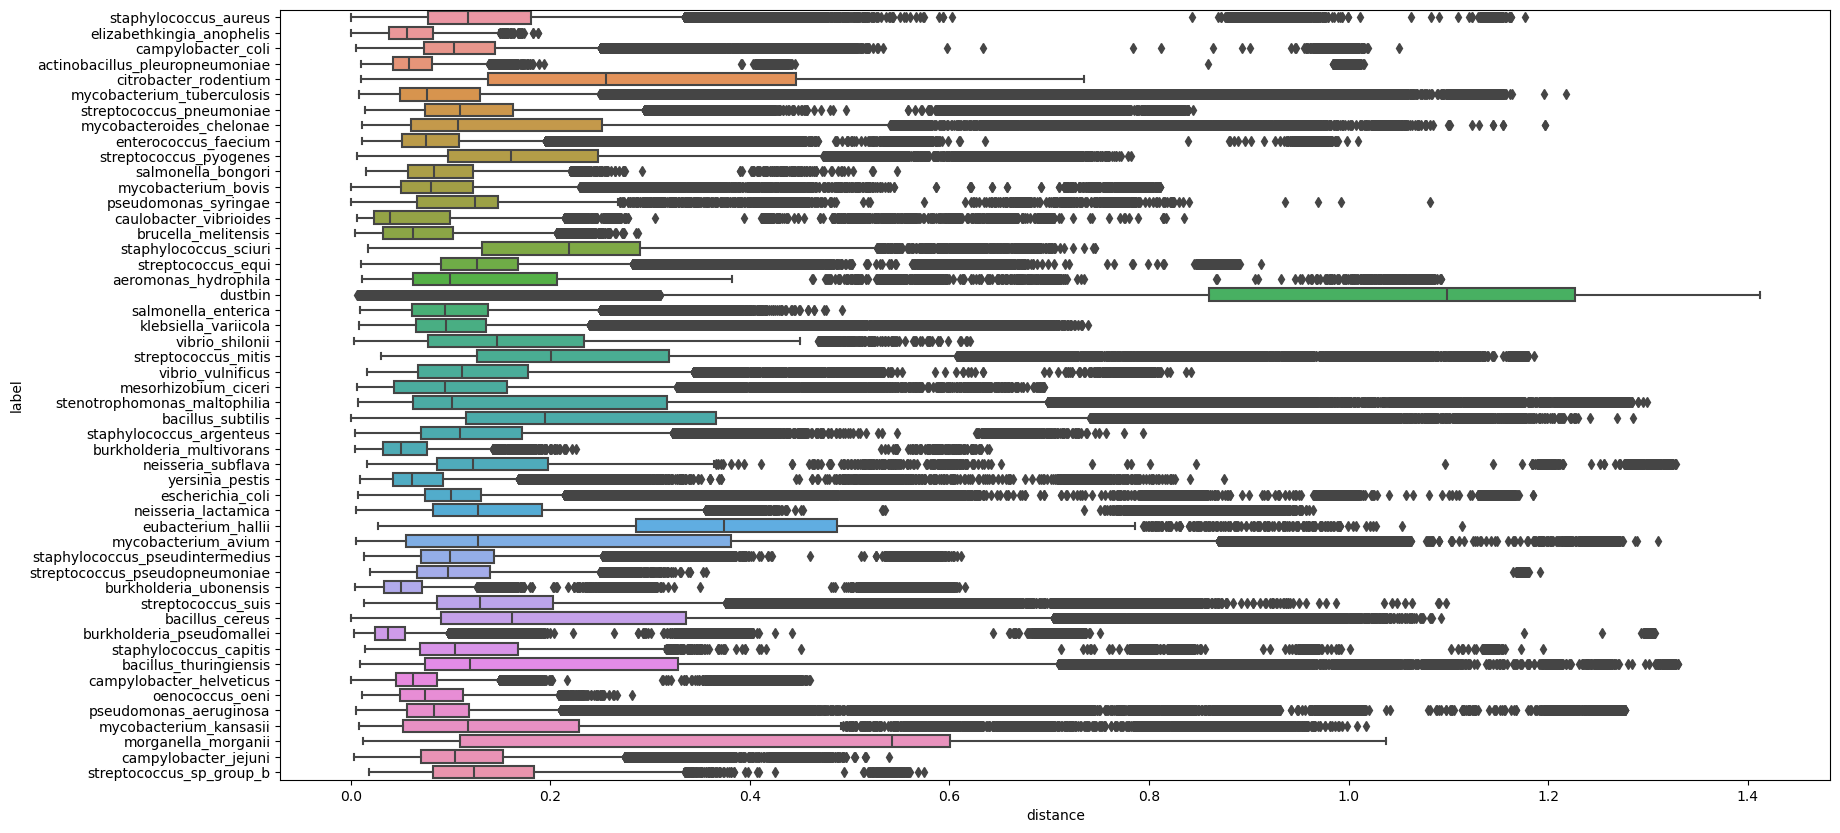

In [175]:
plt.figure(figsize=(20,10))
sns.boxplot(data=df_distances[["label","distance"]], y="label", x="distance", orient="h",)

___

In [190]:
InfoDistSpecies = namedtuple("InfoDist",["label1","label2","distance"])

distances_species=[]
for pos1,label1 in enumerate(unique_labels[1:]):

    emb1 = df_emb.query(f"label == '{label1}'")["embedding"].tolist()[0]
    
    for pos2,label2 in enumerate(unique_labels[pos1+1:]):
            emb2 = df_emb.query(f"label == '{label2}'")["embedding"].tolist()[0]
            d = np.linalg.norm(emb1-emb2)
            distances_species.append(
                InfoDistSpecies(label1,label2,d)
            )

In [193]:
df_distances_species = pd.DataFrame(distances_species)

In [197]:
import scipy.spatial as sp, scipy.cluster.hierarchy as hc

/home/avila/micromamba/envs/train/lib/python3.11/site-packages/seaborn/categorical.py:1794: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: ylabel='distance'>

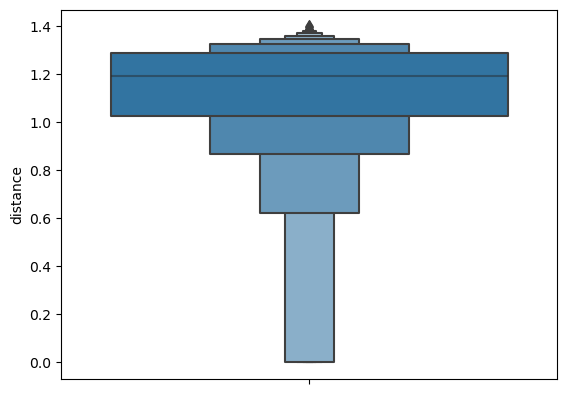

In [196]:
sns.boxenplot(data=df_distances_species, y="distance")

In [200]:
specie2pos = {sp:pos for pos,sp in enumerate(unique_labels)}


In [224]:
n_labels = len(unique_labels)
distance_matrix = np.zeros((n_labels,n_labels))

for record in distances_species:
    row = specie2pos[record.label1]
    col = specie2pos[record.label2]
    distance_matrix[row,col] = record.distance

distance_matrix +=distance_matrix.T
distance /= 2

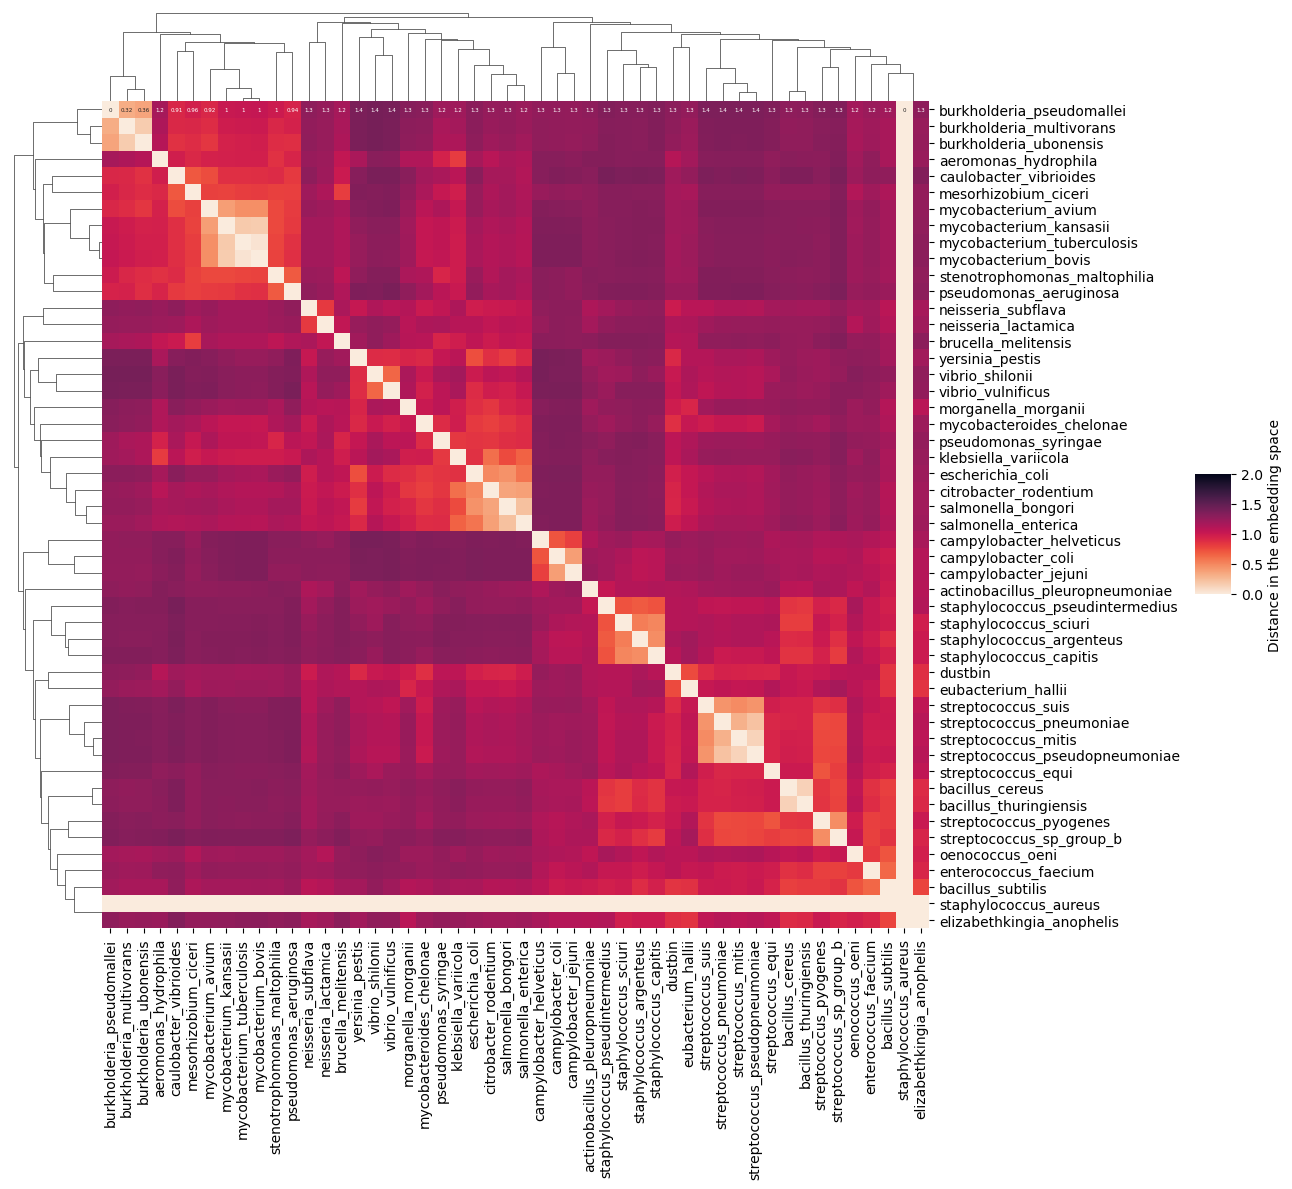

In [228]:
linkage = hc.linkage(sp.distance.squareform(distance_matrix), method='average')
sns.clustermap(
    pd.DataFrame(distance_matrix, index=unique_labels, columns=unique_labels), 
    row_linkage=linkage, col_linkage=linkage, 
    annot=True, annot_kws={"size": 4},
    cmap="rocket_r",
    vmin=0, vmax=2, figsize=(12,12), 
    cbar_pos=(1, 0.5, .03, .1),
    dendrogram_ratio=(.1, .1),
    cbar_kws={"label": "Distance in the embedding space"}
    )